Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 12.5095 - output_10_accuracy: 0.4564 - output_11_accuracy: 0.5223 - output_1_accuracy: 0.5185 - output_2_accuracy: 0.5207 - output_3_accuracy: 0.5055 - output_4_accuracy: 0.5217 - output_5_accuracy: 0.5228 - output_6_accuracy: 0.4918 - output_7_accuracy: 0.5058 - output_8_accuracy: 0.4881 - output_9_accuracy: 0.4953 - val_loss: 9.5586 - val_output_10_accuracy: 0.4900 - val_output_11_accuracy: 0.4800 - val_output_1_accuracy: 0.4450 - val_output_2_accuracy: 0.2600 - val_output_3_accuracy: 0.3250 - val_output_4_accuracy: 0.6700 - val_output_5_accuracy: 0.6250 - val_output_6_accuracy: 0.4700 - val_output_7_accuracy: 0.7700 - val_output_8_accuracy: 0.3400 - val_output_9_accuracy: 0.4350
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.6152 - output_10_accuracy: 0.5020 - output_11_accuracy: 0.5360 - output_1_accuracy: 0.5647 - output_2_accuracy: 0.5233 - output_3_accuracy: 0.5398 - output_4_accuracy: 0.5312 - output_5_a

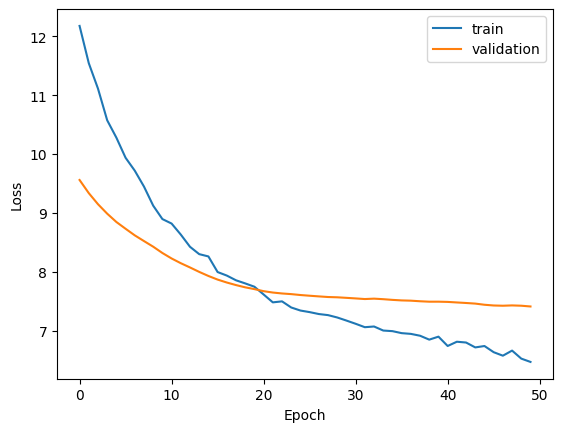

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load your data
X_train = np.load('X_train_normalized.npy')
y_train = np.load('y_train.npy')

# Define the neural network structure with L2 regularization
def build_model(input_shape, num_outputs, l2_reg=0.01):
    inputs = Input(shape=(input_shape,))
    
    # Shared layers with L2 regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Task-specific layers
    outputs = [Dense(1, activation='sigmoid', name=f'output_{i+1}')(x) for i in range(num_outputs)]
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
num_features = X_train.shape[1]
num_targets = y_train.shape[1]
model = build_model(num_features, num_targets)

# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with learning rate schedule and increased regularization
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=['binary_crossentropy']*num_targets,
              metrics=[['accuracy']]*num_targets)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, [y_train[:, i] for i in range(num_targets)],
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)


# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load your data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')

# Define the neural network structure
def build_model(input_shape, num_outputs):
    inputs = Input(shape=(input_shape,))
    
    # Shared layers
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Task-specific output layers
    outputs = []
    for i in range(num_outputs):
        task_specific = Dense(256, activation='relu')(x)  # First task-specific layer
        task_specific = BatchNormalization()(task_specific)
        task_specific = Dropout(0.2)(task_specific)
        task_specific = Dense(128, activation='relu')(task_specific)  # Second task-specific layer
        task_specific = Dropout(0.2)(task_specific)
        task_specific = Dense(128, activation='relu')(task_specific)  # Second task-specific layer
        task_specific = Dropout(0.2)(task_specific)
        task_specific = Dense(128, activation='relu')(task_specific)  # Second task-specific layer
        task_specific = Dropout(0.2)(task_specific)
        task_specific = Dense(128, activation='relu')(task_specific)  # Second task-specific layer
        task_specific = Dropout(0.2)(task_specific)
        task_specific = Dense(64, activation='relu')(task_specific)  # Second task-specific layer
        task_specific = BatchNormalization()(task_specific)
        task_specific_output = Dense(1, activation='sigmoid', name=f'output_{i+1}')(task_specific)
        outputs.append(task_specific_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
num_features = X_train.shape[1]
num_targets = y_train.shape[1]
model = build_model(num_features, num_targets)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=['binary_crossentropy']*num_targets,  # Use binary cross-entropy loss for each output
              metrics=[['accuracy']]*num_targets)  # Specify accuracy for each output

# Fit the model
history = model.fit(X_train, [y_train[:, i] for i in range(num_targets)],
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Save the model if needed
model.save('multitask_model.h5')

# plot



Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 140ms/step - loss: 7.4603 - output_10_accuracy: 0.6885 - output_11_accuracy: 0.7129 - output_1_accuracy: 0.7349 - output_2_accuracy: 0.8077 - output_3_accuracy: 0.7692 - output_4_accuracy: 0.7837 - output_5_accuracy: 0.7722 - output_6_accuracy: 0.7468 - output_7_accuracy: 0.7923 - output_8_accuracy: 0.7793 - output_9_accuracy: 0.6054 - val_loss: 7.0041 - val_output_10_accuracy: 0.7350 - val_output_11_accuracy: 0.7250 - val_output_1_accuracy: 0.6700 - val_output_2_accuracy: 0.7750 - val_output_3_accuracy: 0.8350 - val_output_4_accuracy: 0.7500 - val_output_5_accuracy: 0.7650 - val_output_6_accuracy: 0.7000 - val_output_7_accuracy: 0.7900 - val_output_8_accuracy: 0.7250 - val_output_9_accuracy: 0.6300
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.8183 - output_10_accuracy: 0.7442 - output_11_accuracy: 0.7376 - output_1_accuracy: 0.7401 - output_2_accuracy: 0.7831 - output_3_accuracy: 0.7732 - output_4_accuracy: 0.7867 - output_5_ac